In [1]:
%matplotlib inline
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import matplotlib.pyplot as plt
from scipy.stats import logistic
from scipy.special import softmax

from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.engine import InputSpec
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras.utils import to_categorical
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import cifar10

import tensorflow as tf

from pixelcnn_helpers import pixelcnn_loss, sigmoid, compute_pvals, compute_mixture, PixelConv2D

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [2]:
img_rows, img_cols, img_chns = 4, 4, 3
original_img_size = (img_rows, img_cols, img_chns)

# Debug params
num_sample = 2

# Hyper params
batch_size = int(os.environ.get('BATCH_SIZE', 10))
epochs = int(os.environ.get('EPOCHS', 1000))
learning_rate = float(os.environ.get('LEARNING_RATE', 0.001))
mixture_components = int(os.environ.get('MIXTURE_COMPONENTS', 5))

# Extract Test Image

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Shift/scale to [-1, 1] interval
X_train = X_train[:num_sample, :img_rows, :img_cols, :img_chns]
X_train = (X_train - 127.5) / 127.5

X_test = (X_test - 127.5) / 127.5

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2, 4, 4, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


# Model

In [4]:
if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1
    
    
def conv_block(input_tensor, filters, kernel_size, name, is_first=False):
    outs = []
    for t in ['rb', 'gb', 'bb']:
        if is_first:
            t = t[0] + 'a'
        x = PixelConv2D(t, filters, kernel_size, name='res' + name + t, padding='same')(input_tensor)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)


def resnet_block(input_tensor, filters, stage, block):
    name_base = str(stage) + block + '_branch'
    filters1, filters2, filters3 = filters
    x = input_tensor
    x = conv_block(x, filters1, (1, 1), name=name_base + '_a-1x1')
    x = conv_block(x, filters2, (3, 3), name=name_base + '_b-3x3')
    x = conv_block(x, filters3, (1, 1), name=name_base + '_c-1x1')
    x = Add()([x, input_tensor])
    
    return x


def final_block(input_tensor, filters, in_filters, name, kernel_size=(1, 1)):
    outs = []
    channel_name = 'rgb'
    for t in ['rb', 'gb', 'bb']:
        x = PixelConv2D(t, filters, kernel_size, 
                        name='final' + name + '_' + t,
                        padding='same')(input_tensor)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)


def build_outputs(input_tensor, final_filters):
    m_outs = []
    invs_outs = []
    weights = []
    for t in ['rb', 'gb', 'bb']:
        # Only allow things behind it...
        x = input_tensor
        decoder_out_m = PixelConv2D(t, name='x_m' + str(t),
                                    filters=mixture_components,
                                    kernel_size=1,
                                    strides=1)(x)
        decoder_out_invs_ = PixelConv2D(t, name='x_s' + str(t),
                                        filters=mixture_components,
                                        kernel_size=1,
                                        strides=1,
                                        activation='softplus')(x)
        decoder_out_invs = Lambda(lambda x: 5. * x + 3.0)(decoder_out_invs_)
        mixture_weights = PixelConv2D(t, name='weights' + str(t),
                                      filters=mixture_components,
                                      kernel_size=1,
                                      strides=1)(x)
        m_outs.append(decoder_out_m)
        invs_outs.append(decoder_out_invs)
        weights.append(mixture_weights)
    
    out_m = Concatenate()(m_outs)       
    out_invs = Concatenate()(invs_outs)       
    out_mixture = Concatenate()(weights)       
    return Concatenate()([out_m, out_invs, out_mixture])

In [5]:
# Work around Keras/tensorboard bug: https://github.com/keras-team/keras/issues/10074
K.clear_session()

print("Building conv layers...")
main_input = Input(shape=original_img_size, name='main_input')

x = conv_block(main_input, 256, (7, 7), name='conv1', is_first=True)

resnet_depth = 15
for stage in range(resnet_depth):
    x = resnet_block(x, [128, 128, 256], stage, 'a')
#final_width = 256

final_width = 1024
x = final_block(x, final_width, 256, '1x1_1000_1')
x = final_block(x, final_width, final_width, '1x1_1000_2')

print("Building output layers...")
outputs = build_outputs(x, final_width)
main_output = outputs

print("Building model...")
model = Model(inputs=main_input, outputs=main_output)
optimizer = Adam(lr=0.001)
#optimizer = RMSprop(lr=0.001)
model.compile(optimizer=optimizer, 
              loss=lambda x, y: pixelcnn_loss(x, y, img_rows, img_cols, img_chns, mixture_components))

model.summary()

Building conv layers...
Building output layers...
Building model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 4, 4, 3)      0                                            
__________________________________________________________________________________________________
resconv1ra (PixelConv2D)        (None, 4, 4, 256)    37888       main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ga (PixelConv2D)        (None, 4, 4, 256)    37888       main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ba (PixelConv2D)        (None, 4, 4, 256)    37888       main_input[0][0]                 
_________________________________________

In [ ]:
# early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=1.0, patience=50)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=15, min_lr=0.01 * learning_rate)
filepath='./checkpoints/model-weights-2019-05-30.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto', period=10)

#tensorboard = keras.callbacks.TensorBoard(log_dir='./logs_2019-05-13/' + str(int(time.time() % 10000)),
#                                          histogram_freq=1, batch_size=1,
#                                          write_grads=True, write_images=True, update_freq='batch')

history = model.fit(
    X_train, X_train,
    batch_size=batch_size,
    #epochs=epochs,
    epochs=1000,
    callbacks=[TQDMNotebookCallback(), early_stopping, reduce_lr],#, checkpoint],#, tensorboard],
    #validation_data=(X_train, X_train),
    verbose=0
)

,loss,lr
count,682.000000,682.000000
mean,195.383227,0.000383
std,607.744290,0.000427
min,73.051514,0.000031
0%,73.051514,0.000031
25%,77.476027,0.000031
50%,112.601830,0.000125
75%,207.374260,0.001000
95%,339.316719,0.001000
99%,1116.656462,0.001000


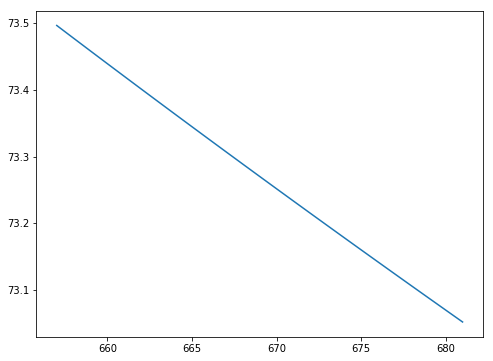

In [7]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df['loss'][-25:].plot(figsize=(8, 6))

In [8]:
#model.load_weights(filepath)
#model.compile(optimizer=optimizer, 
#              loss=lambda x, y: pixelcnn_loss(x, y, img_rows, img_cols, img_chns, mixture_components))

(4, 40, 3)
row 0
row 1
row 2
row 3


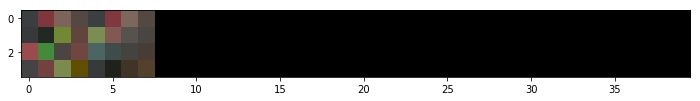

Elapsed:  26.13077712059021


In [9]:
debug = False

def gen_image(model, num_samples=batch_size):
    x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(img_rows):
        for j in range(img_cols):
            for k in range(img_chns):
                # =======================================================
                #x_out = model.predict(X_train, num_samples)
                x_out = model.predict(x_sample, num_samples)
                for n in range(num_samples):
                    offset = k * mixture_components
                    x_ms = x_out[n, i, j, offset:offset + mixture_components]
                    offset = mixture_components * img_chns + k * mixture_components

                    x_invs = x_out[n, i, j, offset:offset + mixture_components]
                    offset = 2 * mixture_components * img_chns + k * mixture_components
                    weights = softmax(x_out[n, i, j, offset:offset + mixture_components])
                    pvals = compute_mixture(x_ms, x_invs, weights, mixture_components)
                    pvals /= (np.sum(pvals) + 1e-5)
                    pixel_val = np.argmax(np.random.multinomial(1, pvals))
                    x_sample[n, i, j, k] = (pixel_val - 127.5) / 127.5
                    if 0 <= i <= 3 and 0 <= j <= 3 and debug:
                        print("====", i, j, k)
                        print("X_train[0", i, j, k, "] = ", X_train[0, i, j, k], 
                              " (%s)" % (X_train[0, i, j, k] * 127.5 + 127.5))
                        print(" m: ", x_ms, "(%s)" % (x_ms * 127.5 + 127.5))
                        print(" E[m]: ", (x_ms * weights).sum(), "(%s)" % (x_ms * 127.5 + 127.5))
                        print(" invs: ", x_invs)
                        print(" weights: ", weights, " (", x_out[n, i, j, offset:offset + mixture_components] ,")")
                        s = pd.Series(pvals)
                        print(" pvals: ", s[s>1e-2])
                        print(" pixel_val: ", pixel_val)
                        samples = pd.Series(np.random.choice(len(pvals), 1000, p=pvals / pvals.sum()))
                        samples.hist(bins=128, alpha=0.5, label='generated')
                        #print("====", i, j, k)
                        #print(" m: ", x_ms)
                        #print(" invs: ", x_invs)
                        #print(" weights: ", weights)
                        #print(" pixel_val: ", pixel_val)
                        #print(" x_out[n, i, j, :]: ", x_out[n, i, j, :])
                        #print(" x_out: ", x_out)
                        #print(" sample_val: ", x_sample[n, i, j, k])
                        #print(" pvals: ", pvals)
        #if debug:
        print("row", i)
        
                
    return (x_sample * 127.5 + 127.5)


start = time.time()

#n = 1 if debug else 10
n = 2
figure = np.zeros((img_rows, img_cols * 10, img_chns))
print(figure.shape)
num_samples = min(n, batch_size)
for i in range(1):
    samples = gen_image(model, num_samples=num_samples)
    for j in range(num_samples):
        img = samples[j] / 255.
        d_x = ((i * batch_size + j) // 10) * img_rows
        d_y = ((i * batch_size + j) % 10) * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols, :] = img
        
plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.show()

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

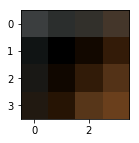

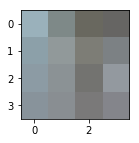

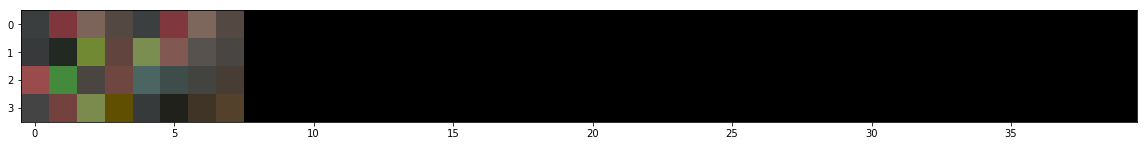

In [11]:
for i in range(num_sample):
    plt.figure(figsize=(2, 2))
    plt.imshow((X_train[i] * 127.5 + 127.5) / 255.)
    plt.show()

plt.figure(figsize=(20, 16))
plt.imshow(figure)
plt.show()

# 2019-06-03

* I *think* I fixed the loss function in two ways:
  * I updated the offset for the exception and normal case, should be correct now
  * I think I was doing an extra `K.sum()` at the end of the loss function, essentially summing up the entire batch's loss vs. just summing each item's loss.  Keras probably takes a `mean` at the end over the batch dimension, so probably no need to do a `sum`.  After this change, the reported loss looks more normal with los bits/pixel.
* Right now, I'm trying smaller examples 4x4 with 2 images using 5 mixture components, I get some funky results, still need to experiment a bit more.  Although, before the `sum` change above, I did get something that looked kind of reasonable.  So it's probably just a bad run, too many mixture components, or maybe the `sum` change is weird.

TODO: Play around a bit more, change mixture components, see if I can get an image that looks reasonable.